## Linear Sturm-Liouville Problem

### Overview:
For details on problem formulation, visit the data folder and view the dataset for System 1.

Noise: None (0% $\sigma$)

Known Operator? No.


### Learning Goals

Knowns: $f_j(x)$ forcing functions and observed responses $u_j(x)$ 

Unknowns: Operator $L$, parametric coefficients $p(x)$ and $q(x)$

----------------

Input: Observations of $u_j(x)$ and the corresponding forcings $f_j(x)$

Output: Operator $L$, including parametric coefficients $p(x)$ and $q(x)$


In [2]:
%load_ext autoreload
%autoreload 2

# Import Python packages
import pickle
import sys
sys.path.append("..")

# Third-Party Imports
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Package Imports
from tools.variables import DependentVariable, IndependentVariable
from tools.term_builder import TermBuilder, build_datapools, NoiseMaker
from tools.differentiator import Differentiator, FiniteDiff
from tools.regressions import *
from tools.NoiseMaker import NoiseMaker
from tools.misc import report_learning_results
from tools.plotter3 import Plotter, compute_coefficients
from tools.Grouper import PointwiseGrouper
from tools.GroupRegressor import GroupRegressor

# Use 0 for seeding random state in data randomization (for consistency)
seed = 0
print("Random seed:", seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Random seed: 0


In [4]:
## Step 1. Load in the data
file_stem = "../data/S1-LSL-"

x_array = pickle.load(open(file_stem +"x.pickle", "rb"))
ode_sols = pickle.load(open(file_stem +"sols.pickle", "rb"))
forcings = pickle.load(open(file_stem + "fs.pickle", "rb"))
sl_coeffs = pickle.load(open(file_stem + "coeffs.pickle", "rb"))

## Step 2. Split data into testing and training
num_trials = 1 # Number of trials to use for observation
sol_train, sol_test, f_train, f_test = train_test_split(ode_sols, forcings, train_size=num_trials, random_state = seed)

## Step 3. Build datapool matrices
# Datapools are a matrix of numerically evaluated terms, which will be used to create each $\Theta^(k)$ to learn $\Xi$

differentiator = Differentiator(diff_order = 2, diff_method = 'FD', ) # finite differences
lhs_term = 'd^{2}u/dx^{2}' # Set LHS term for regression
train_dps = build_datapools(sol_train, differentiator, lhs_term, f_train) # build the matrices using training data

## Step 4. Create group regressor and provide optimization function
# Define the regression function as a lambda function which only expects lists of Thetas, LHSs as inputs
RegFunc = lambda Thetas, LHSs: TrainSGTRidge3(Thetas, LHSs, num_tols = 1, lam = 1e-5, epsilon = 1e-6, normalize = 2)

# Create the group regressor (Uses SGTR regression function above)
groupreg = GroupRegressor(RegFunc, PointwiseGrouper(lhs_term = lhs_term), train_dps, 'x')

C:\Users\shead\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
%%time
## Step 5. Group regression
groupreg.group_regression(known_vars=['u', 'du/dx', 'f', 'd^{2}u/dx^{2}'])  # Regress coefficients
groupreg.report_learning_results()  # Report the learned coefficients

Possible terms:
['u', 'du/dx', 'f']

PDE Find Method:
Minimum Error:  -13823.304008357789
Selected:  3  term(s).
u :  4.483729269539672 -0.01951706264925592 0.14036676488276584
du/dx :  13.18846104710766 0.0247581168926773 0.416111497913668
f :  3.08679015676487 -0.047616031763296054 0.08515555317358986
Wall time: 2.61 s


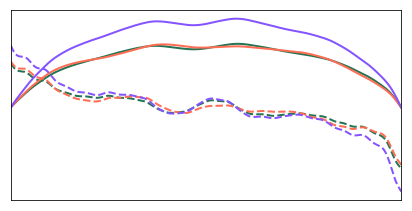

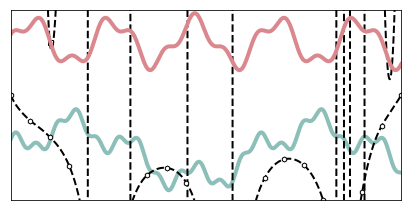

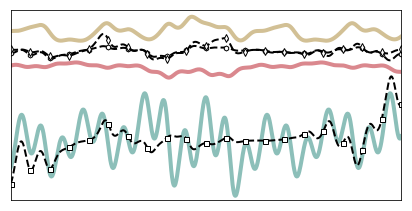

In [7]:
### PLOT RESULTS

# X vector from the first ODE solution
x_vector = ode_sols[0].t

# Construct a plotter object with groupreg (which stores results)
pltr = Plotter(groupreg = groupreg, x_vector = x_vector,
               dependent_variable='u', true_coeffs = sl_coeffs,
               is_sturm_liouville = True, show_legends=False)

# Generate the analysis plots: ODE solutions (first 3), p(x) and q(x), and u_xx model coefficients (entries in Xi)
pltr.generate_analysis_plots(save_stem='3a-KO', 
                             ode_sols=ode_sols,
                             xi_ylims=[-1.7,3.6],
                             coeff_ylims=[-1,2.6])

# Show all the plots (pyplot command)
plt.show()

In [8]:
score_interval = [0.1,9.9]
low_idcs = np.where(pltr.true_x_vector > score_interval[0])
high_idcs = np.where(pltr.true_x_vector < score_interval[1])
idcs = np.intersect1d(low_idcs, high_idcs)

p_error = np.linalg.norm(pltr.inferred_phi[idcs] - pltr.p_x[idcs])/np.linalg.norm(pltr.p_x[idcs])
print('L2 p error: %.4f' % (p_error))

q_error = np.linalg.norm(pltr.inferred_q[idcs] - pltr.q_x[idcs])/np.linalg.norm(pltr.q_x[idcs])
print('L2 q error: %.4f' % (q_error))

L2 p error: 520.6260
L2 q error: 3.1102
